In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import pandas as pd
import numpy as np

import os
from tensorflow.python.layers import core as core_layers

from mpl_toolkits.mplot3d import Axes3D

def reset_graph(seed=42):
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/Users/sara/anaconda2/envs/v_3_6/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/sara/anaconda2/envs/v_3_6/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Import and Clean Data

### Variables in the dataset
ATQ - Total Assets
<br>
COGSQ - Cost of Goods Sold
<br>
CSHOQ - Common Shares Outstanding
<br>
EPSPIQ - Earnings Per Share Including Extraordinary Items
<br>
LTQ - Total Liabilities
<br>
OIADPQ - Operating Income After Depreciation
<br>
SALEQ - Total Revenue
<br>
XOPRQ - Operating Expense
<br>
IBY - Income Before Extraordinary Items
<br>
NIY - Net Income
<br>
PRCCQ - Price (Quarter)

In [3]:
df = pd.read_csv('data.csv',
                 usecols = ['datadate','tic','atq','cogsq','cshoq','epspiq','ltq','oiadpq','saleq','xoprq','iby','niy','prccq','gsector'])
df = df.dropna()
total_tics = df.tic.unique()
print('Number of Stocks used: %d' %len(total_tics))

Number of Stocks used: 14141


### Compute ratios based on fundamental data

In [3]:
df['ROA'] = df['iby'] / df['atq']
df['dROA'] = df['ROA'] - df['ROA'].shift()
df['ROE'] = df['iby'] / (df['atq'] - df['ltq'])
df['dROE'] = df['ROE'] - df['ROE'].shift()
df['ACCRUAL'] = df['niy'] / df['atq']
df['dACCRUAL'] = df['ACCRUAL'] - df['ACCRUAL'].shift()
df['PB'] = df['prccq'] / ((df['atq'] - df['ltq']) / df['cshoq'])
df['Lever'] = df['ltq']/df['atq']
df['dDebt'] = df['ltq'] - df['ltq'].shift()
df['dIncome'] = df['iby'] - df['iby'].shift()
df['Turnover'] = df['saleq'] - df['saleq'].shift()
df['R_Q1'] = df.groupby('tic')['prccq'].pct_change()
df['F_ret'] = df.groupby('tic')['R_Q1'].shift(-1)
df['R_Q2'] = df.groupby('tic')['prccq'].pct_change(2) / 2
df['R_Q3'] = df.groupby('tic')['prccq'].pct_change(3) / 3
df['R_Q4'] = df.groupby('tic')['prccq'].pct_change(4) / 4
df['Margin'] = (df['R_Q1']+df['F_ret']+df['R_Q2']) / 4
df = df.dropna()
df.rename(columns={'datadate': 'Date', 'gsector': 'Sector'}, inplace=True)
df['Sector'].replace(np.nan, 0.0, inplace=True)
df = df[['Date','tic','atq','cogsq','cshoq','epspiq','ltq','oiadpq','saleq','xoprq','iby','niy','prccq','Sector','F_ret',
        'R_Q1','R_Q2','R_Q3','R_Q4','ROA','dROA','ROE','dROE','ACCRUAL','dACCRUAL','PB','Margin','Lever','dDebt','dIncome','Turnover']]

df.to_csv('ret_data.csv', index=False)
df.head()

,Date,tic,atq,cogsq,cshoq,epspiq,ltq,oiadpq,saleq,xoprq,...,ROE,dROE,ACCRUAL,dACCRUAL,PB,Margin,Lever,dDebt,dIncome,Turnover
4,20070228,AIR,1010.849,215.774,37.228,0.42,541.148,22.505,270.978,240.544,...,0.088844,0.030759,0.040375,0.014849,2.304850,0.090744,0.535340,-8.632,15.519,26.706
5,20070531,AIR,1067.633,241.969,37.729,0.49,573.390,27.016,305.677,270.551,...,0.120279,0.031435,0.054944,0.014569,2.480951,0.048723,0.537067,32.242,17.717,34.699
6,20070831,AIR,1076.976,239.814,37.712,0.41,567.596,25.878,305.960,270.476,...,0.029948,-0.090331,0.014070,-0.040874,2.324702,0.014409,0.527028,-5.794,-44.192,0.283
7,20071130,AIR,1137.290,240.512,37.723,0.49,606.963,29.409,310.647,271.453,...,0.062495,0.032547,0.029023,0.014953,2.348765,-0.039084,0.533692,39.367,17.888,4.687
8,20080229,AIR,1333.454,295.910,38.738,0.54,768.958,36.298,376.626,329.917,...,0.094647,0.032152,0.039824,0.010800,1.776677,-0.139745,0.576666,161.995,20.285,65.979


## Check for valid inputs
### Set year 2017 return for validation, trim stock outliers

In [4]:
df = pd.read_csv('ret_data.csv')

In [5]:
# use year 2017 data for prediction and testing
df['Year'] = df.Date.apply(str)
df.Year = df.Year.str[:4].astype(int)
df2017 = df[df.Year == 2017]
ticlist = df2017.groupby(['tic']).size()>3
ticlist = ticlist[ticlist]
tics = ticlist.index.tolist()

# trim outliers
outliers = ['GNBT', 'LNGG', 'CSBR', 'ORGS', 'IPCI', 'CDK', 'CJ', 'SRBCF', 'LTXFF', 'IRWD', 'NRT','COOL',
           'HRB','MMTIF','QURE','BA','ABMT','CTUMF','ARCH','ASPU','CODA','SVU','MET','ITUS','GRVY',
           'MMEX','PNCKF','ADRGF','FTR','WLL','CIIT','FVGCF','ETAH','DNKN','W']
for outlier in outliers:
    tics.remove(outlier)
print('Stocks with valid return in 2017: %d' %len(tics))

Stocks with valid return in 2017: 1678


In [6]:
# split data before 2017 or after 2017
df = df[df.Year <= 2017]
d_17 = df[df.Year >= 2017]
d_17 =  d_17[d_17.tic.isin(tics)]
df = df[df.tic.isin(tics)]
df = df[~df.index.isin(d_17.index)]

### Trim outliers in predictors 

In [7]:
low_cut = 10  # in percents
high_cut = 90

predictors = ['R_Q1','R_Q2','R_Q3','R_Q4','ROA','dROA','ROE','dROE','ACCRUAL','dACCRUAL','PB','Margin','Lever','dDebt','dIncome','Turnover']

for col in predictors:
    low_percentile = np.percentile(df[col], low_cut)
    high_percentile = np.percentile(df[col], high_cut)
    print(col,low_percentile, high_percentile)
    idx_low_val = np.logical_not(df[col] > low_percentile)
    idx_high_val = np.logical_not(df[col] < high_percentile)
    df.loc[idx_low_val, col] = np.nan
    df.loc[idx_high_val, col] = np.nan
df = df.dropna()
df[predictors].describe()

R_Q1 -0.20000000000000007 0.24372511008578807
R_Q2 -0.1395594883736036 0.18765854618943667
R_Q3 -0.11264131227696617 0.15799566601417522
R_Q4 -0.09537191788672572 0.13942307692307693
ROA -0.01283846103325186 0.08312860177476278
dROA -0.05336055353560629 0.03350669487084119
ROE -0.032745826568439995 0.1854953157402811
dROE -0.12049998895709711 0.07372618003172257
ACCRUAL -0.013647838884362013 0.08424832780116309
dACCRUAL -0.05449606487550754 0.03395473155108494
PB 0.7477018234273439 5.647157549701452
Margin -0.0881317627544135 0.12492926153076564
Lever 0.21849790705259559 0.9063878743903813
dDebt -164.83429999999987 387.7289000000012
dIncome -128.388 238.15330000000034
Turnover -93.40780000000001 142.26400000000046


,R_Q1,R_Q2,R_Q3,R_Q4,ROA,dROA,ROE,dROE,ACCRUAL,dACCRUAL,PB,Margin,Lever,dDebt,dIncome,Turnover
count,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000
mean,0.017642,0.018265,0.019721,0.019775,0.022133,0.004454,0.056000,0.009485,0.022493,0.004447,1.898573,0.014867,0.610160,29.371392,17.498886,6.909299
std,0.093580,0.065118,0.053769,0.047937,0.021089,0.014287,0.040474,0.034363,0.021135,0.014496,0.986052,0.043706,0.207907,85.269772,45.961042,30.741066
min,-0.199878,-0.139456,-0.112590,-0.095285,-0.012731,-0.053232,-0.032543,-0.119784,-0.013349,-0.054447,0.747854,-0.088030,0.218628,-164.770000,-128.116000,-93.393000
25%,-0.047934,-0.026768,-0.017658,-0.013379,0.005479,0.000964,0.024036,0.003994,0.005642,0.000982,1.166252,-0.015360,0.444727,-10.924000,0.847000,-1.655000
50%,0.015478,0.016237,0.018095,0.017857,0.014435,0.004143,0.050508,0.018749,0.014970,0.004286,1.592151,0.014659,0.589603,7.133000,7.826000,1.011000
75%,0.083123,0.061669,0.056356,0.051690,0.035459,0.013240,0.082803,0.029119,0.035972,0.013390,2.362739,0.044773,0.846296,49.022000,28.280000,11.810000
max,0.243483,0.187614,0.157833,0.139357,0.083121,0.033482,0.185379,0.073708,0.083896,0.033591,5.641741,0.124829,0.906375,386.880000,238.000000,142.082000


In [8]:
print(np.sum(df.F_ret.isnull()))

0


In [9]:
print(df.Sector.unique())

[20. 45. 25. 15. 10. 40. 60. 55. 30. 35. 50.]


### Check the statistics of stocks from different sectors

In [10]:
# make a dictionary and inverse dictionary for industry sectors
sectors = dict(zip(df["Sector"].unique(), range(0, len(df["Sector"].unique()))))

### Define the train and test datasets

In [11]:
# one-fourth of the data with be used for a test set
test_size = len(df) // 4
tic_last_set = d_17

# all outputs (predict the next-quarter return)

Y = df.F_ret.values
Y_tic_last_set = tic_last_set.F_ret.values

X_raw = df[predictors].values
X_tic_last_set_raw = tic_last_set[predictors].values

# standardize inputs
X = (X_raw - np.mean(X_raw, axis=0, keepdims=True)) / (0.00000001 + np.std(X_raw, axis=0, keepdims=True))
X_tic_last_set = (X_tic_last_set_raw - np.mean(X_raw, axis=0)) / (0.00000001 + np.std(X_raw, axis=0))

# sector values
X_sector = df.Sector.values
X_tic_last_set_sector = tic_last_set.Sector.values

# randomly select a set of rows that will be used for a test
test_ids = np.random.randint(low=0, high=Y.shape[0], size=test_size)

# construct indices for the train set by excluding indices for the test set
train_ids =  np.arange(0, Y.shape[0])
train_ids = train_ids[np.logical_not(np.in1d(train_ids, test_ids))]

# make input datasets 
X_train = X[train_ids, :]
X_train_sectors = X_sector[train_ids] # for categorical sector values
Y_train = Y[train_ids]

# test datasets
X_test  = X[test_ids, :]
X_test_sectors = X_sector[test_ids]
Y_test  = Y[test_ids]

print (X_train.shape, X_train_sectors.shape, Y_train.shape, X_test.shape, X_test_sectors.shape, Y_test.shape)

(9367, 16) (9367,) (9367,) (3002, 16) (3002,) (3002,)


In [12]:
np.mean(X_raw, axis=0).shape

(16,)

# Learning with ANN
## A Class for Neural Network

In [16]:
class Model:
    def __init__(self, n_input, n_output, hidden_layer_shapes=[32], 
                 activation=tf.nn.relu, optimizer = tf.train.GradientDescentOptimizer,
                num_sectors=len(sectors)):
        
        self.x = tf.placeholder(tf.float32, shape=(None, n_input), name="X")
        self.x_sectors = tf.placeholder(tf.int32, shape=(None), name="X_sectors")
        self.y = tf.placeholder(tf.float32, shape=(None, n_output), name="y")
        
        self.learning_rate = tf.placeholder(tf.float32, name="learning_rate")
        
        # dropout specification
        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        
        # use a one-hot representation for sector ID values
        x_sectors_one_hot = tf.one_hot(self.x_sectors, num_sectors)
        
        # include the output layer in the list of layers
        hidden_layer_shapes_full = hidden_layer_shapes + [n_output]
        
        # add "one-hot" boolean sector variables to the data
        previous_layer_output = tf.concat([self.x, x_sectors_one_hot], axis=-1)
        
        previous_layer_size = n_input + num_sectors
        
        # define all layers
        for i in range(0, len(hidden_layer_shapes_full)):
            if i < (len(hidden_layer_shapes_full) - 1):
                # inner (hidden) layer
                hidden_layer = tf.layers.Dense(hidden_layer_shapes_full[i], activation=activation)   
            else:
                # output layer
                hidden_layer = tf.layers.Dense(hidden_layer_shapes_full[i])
                
            hidden_layer.build([None, previous_layer_size])
            
            # output of a hidden layer is an iput to the next layer
            previous_layer_output = hidden_layer(previous_layer_output)
            
            # apply a dropout to hidden layers
            if i < (len(hidden_layer_shapes_full) - 1):
                previous_layer_output = tf.nn.dropout(previous_layer_output, keep_prob=self.keep_prob)   
            
            # also redefine the size of the previous layer as the size of the current layer 
            previous_layer_size = hidden_layer_shapes_full[i]
        
        # define other ops
        self.loss = tf.reduce_mean(tf.square(previous_layer_output - self.y))
        self.train_op = (optimizer(self.learning_rate).minimize(self.loss), self.loss)
        self.output = previous_layer_output

## Create a Neural Network model

Saved session to ./feed_fwd_nn_eps.ckpt


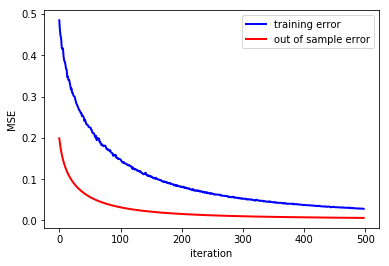

In [19]:
model = Model(n_input=X.shape[1], n_output=1, hidden_layer_shapes=[60])

batch_size = 256
learning_rate = 0.01
n_iters = 50000
keep_prob = 0.6 # 1 - dropout rate

history = []
load_model_from_disk = False

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if load_model_from_disk:
        try:
            saver.restore(sess, './feed_fwd_nn_eps.ckpt')
            print ("model loaded")
        except:
            print ("model not loaded")
        
    losses = []
    for i in range(0, n_iters):
        batch_ids = np.random.randint(low=0, high=Y_train.shape[0], size=batch_size).tolist()
        batch_x = X_train[batch_ids, :]
        batch_x_sectors = X_train_sectors[batch_ids]
        
        batch_y = Y_train[batch_ids]
        _, loss = sess.run(model.train_op, feed_dict={
            model.x: batch_x,
            model.x_sectors: batch_x_sectors,
            model.y: np.expand_dims(batch_y, -1),
            model.learning_rate: learning_rate,
            model.keep_prob: keep_prob
        })
        losses.append(loss)
        if len(losses) % 100 == 0:
            test_loss = sess.run(model.loss, feed_dict={
                model.x: X_test,
                model.x_sectors: X_test_sectors,
                model.y: np.expand_dims(Y_test, -1),
                model.keep_prob: 1.0
            })
            train_loss = sess.run(model.loss, feed_dict={
                model.x: X_train,
                model.x_sectors: X_train_sectors,
                model.y: np.expand_dims(Y_train, -1),
                model.keep_prob: 1.0
            })
            
            history.append([np.mean(losses), train_loss, test_loss])
            losses = []
    save_path = saver.save(sess, './feed_fwd_nn_eps.ckpt')
    print('Saved session to %s' % save_path)
    

reset_graph(seed=42)
plt.figure()
history = np.array(history)
a, = plt.plot(history[2:,0], c="#0000FF", label="training error", linewidth=2.0)
#b, = plt.plot(history[2:,1], c="#000000", label="in sample error (no dropout)", linewidth=1.0)
c, = plt.plot(history[2:,2], c="#ff0000", label="out of sample error", linewidth=2.0)
plt.legend(handles=[a,c])
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.savefig('training.eps', format='eps', dpi=1000)

In [14]:
print(history[-1,2])

0.0068871127


### Validation of the model

In [25]:
# choose the number of hidden layers with minimum mse
def opt_layer(layers):
    batch_size = 256
    learning_rate = 0.01
    n_iters = 50000
    keep_prob = 0.6 # 1 - dropout rate
    min_loss = 99999999
    good_l = []
    for l in layers:    
        reset_graph()
        model = Model(n_input=X.shape[1], n_output=1, hidden_layer_shapes=l)
        history = []
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(0, n_iters):
                batch_ids = np.random.randint(low=0, high=Y_train.shape[0], size=batch_size).tolist()
                batch_x = X_train[batch_ids, :]
                batch_x_sectors = X_train_sectors[batch_ids]

                batch_y = Y_train[batch_ids]
                _, loss = sess.run(model.train_op, feed_dict={
                    model.x: batch_x,
                    model.x_sectors: batch_x_sectors,
                    model.y: np.expand_dims(batch_y, -1),
                    model.learning_rate: learning_rate,
                    model.keep_prob: keep_prob
                })
                if len(losses) % 100 == 0:
                    test_loss = sess.run(model.loss, feed_dict={
                        model.x: X_test,
                        model.x_sectors: X_test_sectors,
                        model.y: np.expand_dims(Y_test, -1),
                        model.keep_prob: 1.0
                    })
                    history.append(test_loss)
            if history[-1]<min_loss:
                min_loss = history[-1]
                good_l = l
        print('hidden layer = '+' '.join(str(e)+' ' for e in l)+', error = %.5f' % (history[-1]))
    return(good_l)

### Choose a proper hidden layer number

In [26]:
# one hidden layer
L1 = opt_layer([[30],[90],[150]])

hidden layer = 30 , error = 0.00053
hidden layer = 90 , error = 0.00017
hidden layer = 150 , error = 0.00013


In [29]:
# two hidden layers
L2 = opt_layer([[10,10], [40,20], [80,40]])

hidden layer = 10  10 , error = 0.00319
hidden layer = 40  20 , error = 0.00221
hidden layer = 80  40 , error = 0.00094


In [80]:
opt_layer([[10,10],[160, 40]])

hidden layer = 10  10 , error = 0.00319
hidden layer = 160  40 , error = 0.00073


[160, 40]

In [28]:
# three hidden layers
L3 = opt_layer([[20,10,10], [40,20,20], [80,60,40]])

hidden layer = 20  10  10 , error = 0.00720
hidden layer = 40  20  20 , error = 0.00470
hidden layer = 80  60  40 , error = 0.00273


In [37]:
# choose a proper layer
L = [150]

# Prediction and validation

In [47]:
def predict_layer(best_layer,X_tic_last,X_tic_sectors,Y_tic_last):
    reset_graph()
    batch_size = 256
    learning_rate = 0.01
    n_iters = 50000
    keep_prob = 0.6 # 1 - dropout rate
    model = Model(n_input=X.shape[1], n_output=1, hidden_layer_shapes=best_layer)
    pd_y_tic_last =[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(0, n_iters):
            batch_ids = np.random.randint(low=0, high=Y_train.shape[0], size=batch_size).tolist()
            batch_x = X_train[batch_ids, :]
            batch_x_sectors = X_train_sectors[batch_ids]
            batch_y = Y_train[batch_ids]
            _, loss = sess.run(model.train_op, feed_dict={
                model.x: batch_x,
                model.x_sectors: batch_x_sectors,
                model.y: np.expand_dims(batch_y, -1),
                model.learning_rate: learning_rate,
                model.keep_prob: keep_prob
            })
        pd_y_tic_last = sess.run(model.output, feed_dict={
            model.x: X_tic_last,
            model.x_sectors: X_tic_sectors,
            model.y: np.expand_dims(Y_tic_last, -1),
            model.keep_prob: 1.0
        })         
    return(pd_y_tic_last)

In [48]:
prd_ret = predict_layer(L,X_tic_last_set,X_tic_last_set_sector,Y_tic_last_set)
tic_last_set['Predict'] = prd_ret
tic_last_set['Accuracy'] = tic_last_set.F_ret * tic_last_set.Predict
accuracy = tic_last_set[tic_last_set.Accuracy>0].shape[0] / tic_last_set.shape[0]
print("Prediction accuracy: %.3f" % accuracy)

Prediction accuracy: 0.917


In [49]:
f_ret = tic_last_set['F_ret']
f_ret = f_ret.values
diff = f_ret.reshape(1,-1) - prd_ret.reshape(1,-1)
sse = np.sum(np.square(diff))
print('Mean square error is %.3f' % (np.sqrt(sse) / f_ret.shape[0]))

Mean square error is 0.010


In [50]:
sort_by_predict = tic_last_set.sort_values(by=['Predict'])
positive_return = sort_by_predict[sort_by_predict['Predict']>0]
print('Stocks with predicted positive return: %.i' % positive_return.shape[0])

Stocks with predicted positive return: 3765


In [51]:
negative_return = sort_by_predict[sort_by_predict['Predict']<0]
print('Stocks with predicted negative return: %.i' % negative_return.shape[0])

Stocks with predicted negative return: 2951


In [72]:
tk_rate = 0.06
positive_count = positive_return.shape[0]
positive_top = positive_return.iloc[int(positive_count*(1-tk_rate)):,:]
negative_count = negative_return.shape[0]
negative_top = negative_return.iloc[:int(negative_count*tk_rate),:]
print('long position return %.4f' % np.mean(positive_top['F_ret']))
print('short position return %.4f' % np.mean(negative_top['F_ret']))

long position return 0.9820
short position return -0.2607


/Users/sara/anaconda2/envs/v_3_6/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


AVG RET of LONG STOCKS [0.5228686286614528, 0.32223369926041145, 0.3582101481844514, 0.9819611679052273]
AVG RET of SHORT STOCKS [-0.17771395812331459, -0.2611310912249862, -0.2686279693166605, -0.2606748780361402]
SHARPE RATIO of MKt [0.01292357931908991, 0.1251930153477642, 0.056579834116595396, 0.005254031825872989]
SHARPE RATIO of REAL PORTFOLIO [0.5709798984111139, 1.0505216864564964, 1.298421537546731, 0.2295710702028748]
SHARPE RATIO of PREDICTED PORTFOLIO [0.35521306482939846, 0.3824084664565892, 1.0324000354291205, 0.44878555766774675]


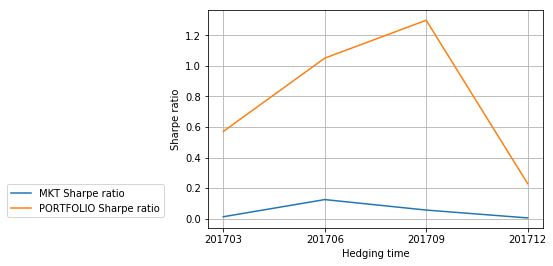

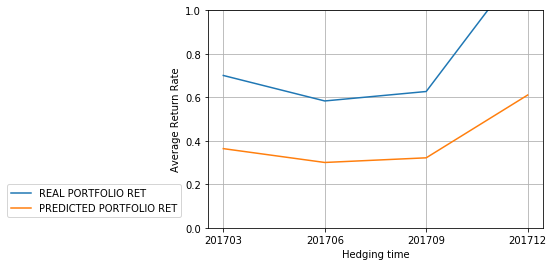

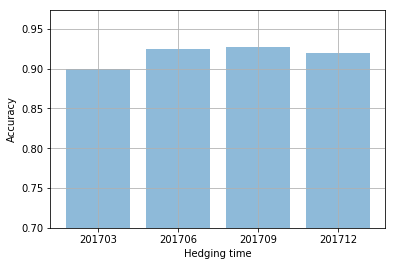

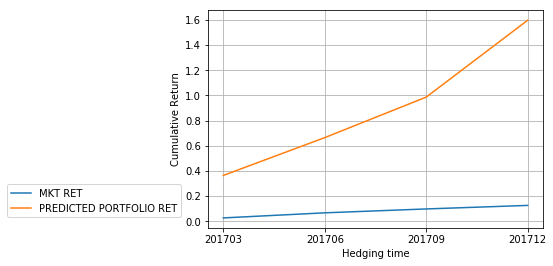

In [76]:
port_return = tic_last_set[['Date','tic','F_ret','Predict']]
port_return['tmp'] = port_return.index.values
long_ret = []
short_ret = []
r_f_rate = [0.02404,0.02187,0.02275,0.02462]
mkt_sr = []
port_sr = []
prd_sr =[]
mkt_avg_r = [] #[0.01189,0.04155,0.04724,0.10185]
prd_avg_r = []
accuracy = []
date = ['201703','201706','201709','201712']
for i in range(4):
    port_r =[]
    returndf = port_return.groupby('tic').first().sort_values(by=['Predict'])
    positive_return = returndf[returndf['Predict']>0]
    negative_return = returndf[returndf['Predict']<0]
    positive_count = positive_return.shape[0]
    positive_top = positive_return.iloc[int(positive_count*(1-tk_rate)):,:]
    long_ret.append(np.mean(positive_top['F_ret']))
    negative_count = negative_return.shape[0]
    negative_top = negative_return.iloc[:int(negative_count*tk_rate),:]
    short_ret.append(np.mean(negative_top['F_ret']))
    port_return = port_return[~port_return.tmp.isin(returndf.tmp)]
    mkt_sr.append((np.mean(returndf['F_ret'])-r_f_rate[i])/np.std(returndf['F_ret']))
    port_r = np.concatenate([positive_top['F_ret'].values,-negative_top['F_ret'].values])
    port_sr.append((np.mean(port_r)-r_f_rate[i])/np.std(port_r))
    prd_r = np.concatenate([positive_top['Predict'].values,-negative_top['Predict'].values])
    prd_sr.append((np.mean(prd_r)-r_f_rate[i])/np.std(prd_r))
    mkt_avg_r.append(np.mean(returndf['F_ret']))
    prd_avg_r.append(np.mean(port_r))
    accuracy.append((positive_return[positive_return['F_ret']>0].shape[0]+\
     negative_return[negative_return['F_ret']<0].shape[0])\
    /(positive_return.shape[0]+negative_return.shape[0]))
print('AVG RET of LONG STOCKS',long_ret)
print('AVG RET of SHORT STOCKS',short_ret)
print('SHARPE RATIO of MKt',mkt_sr)
print('SHARPE RATIO of REAL PORTFOLIO',port_sr)
print('SHARPE RATIO of PREDICTED PORTFOLIO',prd_sr)
plt.figure(1)
plt.plot(date,mkt_sr)
plt.plot(date,port_sr)
#plt.plot(date,prd_sr)
plt.grid(True)
plt.xlabel('Hedging time')
plt.ylabel('Sharpe ratio')
plt.legend(['MKT Sharpe ratio','PORTFOLIO Sharpe ratio'],bbox_to_anchor=(-0.6, 0.2), loc=2, borderaxespad=0.)
plt.show()
#plt.savefig('SR.eps', format='eps', dpi=1000)
plt.figure(2)
#plt.plot(date,mkt_avg_r)
plt.plot(date,np.array(long_ret)-np.array(short_ret))
plt.plot(date,prd_avg_r)
plt.grid(True)
plt.ylim(ymin=0.0, ymax=1.0)
plt.xlabel('Hedging time')
plt.ylabel('Average Return Rate')
plt.legend(['REAL PORTFOLIO RET','PREDICTED PORTFOLIO RET'],bbox_to_anchor=(-0.6, 0.2), loc=2, borderaxespad=0.)
plt.show()
#plt.savefig('Avg_Ret.eps', format='eps', dpi=1000)
plt.figure(3)
plt.bar(date,accuracy, align='center', alpha=0.5)
plt.ylim(ymin=0.7)
plt.grid(True)
plt.xlabel('Hedging time')
plt.ylabel('Accuracy')
plt.show()
#plt.savefig('Accuracy.jpg', format='jpg', dpi=1000)
plt.figure(4)
plt.plot(date,np.cumsum(mkt_avg_r))
#plt.plot(date,np.cumsum(np.array(long_ret)-np.array(short_ret)))
plt.plot(date,np.cumsum(prd_avg_r))
plt.grid(True)
plt.xlabel('Hedging time')
plt.ylabel('Cumulative Return')
plt.legend(['MKT RET','PREDICTED PORTFOLIO RET'],bbox_to_anchor=(-0.6, 0.2), loc=2, borderaxespad=0.)
plt.show()

In [81]:
returndf
positive_top
returndf['F_ret']
np.array(long_ret)-np.array(short_ret)

array([0.44733057, 0.44270168, 0.35099996, 0.57458219])

In [70]:
(np.array(long_ret)-np.array(short_ret))[-1]

0.779540938693779

In [79]:
negative_count*tk_rate

52.14